# Identify Cascading Dependencies

Studies the dependency file to figure out the extent to which there exist cascading dependencies; i.e., dependencies such that $A \to B \to C \to ...$, where $A,B,...$ are projects.

In [1]:
%reload_ext autoreload
%autoreload 2

## Load dependencies

In [2]:
def print_perc(count, total):
    perc = count / total * 100
    print(f'{count} / {total} ({perc:.3f}%)')

In [3]:
import pandas as pd
import python_proj.utils.exp_utils as exp_utils


data_path_format = exp_utils.BASE_PATH + "/final_data/{data_file_name}.csv"

# Details for loading non-obfuscated data.
input_data_file_name = "non_ftc_data"
data_path = data_path_format.format(data_file_name=input_data_file_name)
print(f"{data_path=}")

# Details obfuscated data if necessary.
obf_input_data_file_name = "non_ftc_data_obfuscated"
obf_data_path = data_path_format.format(data_file_name=obf_input_data_file_name)

# Loads the data
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

print(f"{len(df)=}.")
print(f"{len(df.columns)=}\n")

df.describe()

data_path='/workspaces/msc_thesis/data//final_data/non_ftc_data.csv'
len(df)=1815972.
len(df.columns)=155



,ID,Submitter ID,PR Number,ControlPullRequestLifeTimeInMinutes,ControlNumberOfCommitsInPullRequest,IntraProjectSecondOrderInDegreeCentrality(PRIntegratorToSubmitterV2.PRIntegratorToSubmitterV2-In),IntraProjectSecondOrderInDegreeCentrality(PRIntegratorToSubmitterV2.PRCommenterToSubmitterV2-In),IntraProjectSecondOrderInDegreeCentrality(PRIntegratorToSubmitterV2.PRCommenterToCommenterV2-In),IntraProjectSecondOrderInDegreeCentrality(PRIntegratorToSubmitterV2.IssueCommenterToCommenterV2-In),IntraProjectSecondOrderInDegreeCentrality(PRIntegratorToSubmitterV2.IssueCommenterToSubmitterV2-In),...,EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter,EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter,EcosystemExperienceSubmitterIssueSubmissionCount,EcosystemExperienceSubmitterIssueCommentCount,DependencyEcosystemExperienceSubmitterIssueSubmissionCount,DependencyEcosystemExperienceSubmitterIssueCommentCount,NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount,NonDependencyEcosystemExperienceSubmitterIssueCommentCount,InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount,InversedDependencyEcosystemExperienceSubmitterIssueCommentCount
count,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,...,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06,1.815972e+06
mean,1.474751e+08,5.198276e+06,3.807207e+03,3.190111e+04,4.947501e+00,3.926438e+01,1.076084e+01,1.262702e+01,8.083162e+00,8.484018e+00,...,8.594130e-02,1.475467e+00,2.615631e+00,1.785944e+01,1.743463e-01,8.645552e-01,2.274088e+00,1.570265e+01,1.854588e-01,1.355166e+00
std,1.004294e+08,8.100370e+06,8.071615e+03,1.399335e+05,7.283362e+01,2.497234e+03,3.186353e+02,4.506868e+02,3.652262e+02,1.962613e+02,...,1.285316e+00,2.382904e+01,7.985540e+00,6.700519e+01,1.580686e+00,1.186131e+01,7.064174e+00,6.131080e+01,2.446396e+00,1.667164e+01
min,6.870000e+02,1.000000e+00,1.000000e+00,1.666667e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.807322e+07,4.631570e+05,1.000000e+02,5.290000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.371940e+08,1.620265e+06,5.480000e+02,9.799167e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.278026e+08,6.384100e+06,2.817000e+03,7.328350e+03,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
max,3.617756e+08,5.976123e+07,8.297600e+04,4.489490e+06,1.000000e+04,3.461280e+05,8.789200e+04,1.227920e+05,1.095040e+05,4.764000e+04,...,2.190000e+02,5.687000e+03,2.332000e+03,7.630000e+03,3.730000e+02,9.270000e+02,2.332000e+03,7.630000e+03,7.410000e+02,2.764000e+03


In [4]:
from python_proj.data_preprocessing.sliding_window_features.dependency_ecosystem_experience.dependency_loading import (
    filter_dependencies,
)

In [5]:
# Filters dependencies based on the projects that are included in the dataset.

project_ids = set(df["Project Name"].unique())
print(f"{len(project_ids)=}")

del df

dependencies, project_name_to_id = filter_dependencies(project_ids, map_name_to_id=True)
print(f"{len(dependencies)=}, {len(project_name_to_id)=}")

project_count = len(project_name_to_id)

del project_ids

len(project_ids)=20052
Attempting quick load dependencies.
Loading projects and dependencies from: "/workspaces/msc_thesis/data/libraries/npm-libraries-1.6.0-2020-01-12/ql_dependencies.csv".
Finished quick load!
Loaded 631066 projects and 1695834 projects with dependencies.
Loaded dependency data in 0:00:29.154408.
No. included projects after mapping: 20041.
len(dependencies)=19609, len(project_name_to_id)=20041


## Presence of dependencies

In [6]:
upstream_projects = set()

for upstream_ids in dependencies.values():
    upstream_projects = upstream_projects.union(upstream_ids)

In [7]:
upstream_count = 0
downstream_count = 0
upstream_or_downstream_count = 0

for proj_name, proj_id in project_name_to_id.items():
    is_downstream = proj_id in dependencies

    if is_downstream:
        downstream_count += 1

    is_upstream = proj_id in upstream_projects
    if is_upstream:
        upstream_count += 1

    if is_upstream or is_downstream:
        upstream_or_downstream_count += 1

print("# Upstream, # Downtream, # Upstream or downstream:")
print_perc(upstream_count, project_count)
print_perc(downstream_count, project_count)
print_perc(upstream_or_downstream_count, project_count)

# Upstream, # Downtream, # Upstream or downstream:
8688 / 20041 (43.351%)
19609 / 20041 (97.844%)
19829 / 20041 (98.942%)


## Presence of cascading dependencies

In [10]:
def calculate_cascade(level: int) -> int:
    count = 0
    proj_ids = set(dependencies.keys())
    for proj_id in proj_ids:
        if _has_cascade(level, proj_id):
            count += 1
    return count


def _has_cascade(level: int, project_id: int) -> bool:
    if project_id not in dependencies:
        return False
    proj_deps = dependencies[project_id]
    if level == 0:
        return len(proj_deps) > 0
    has_cascading = any(_has_cascade(level - 1, dep) for dep in proj_deps)
    return has_cascading

In [11]:
cascade_counts = []

# The results plateau around 89%
for level in range(1, 10):
    cascade_count = calculate_cascade(level)
    cascade_counts.append((level, cascade_count))
    print(f"Cascade level {level}:")
    print_perc(cascade_count, project_count)

Cascade level 1:
16774 / 20041 (83.698%)
Cascade level 2:
16646 / 20041 (83.060%)
Cascade level 3:
16600 / 20041 (82.830%)
Cascade level 4:
16580 / 20041 (82.730%)


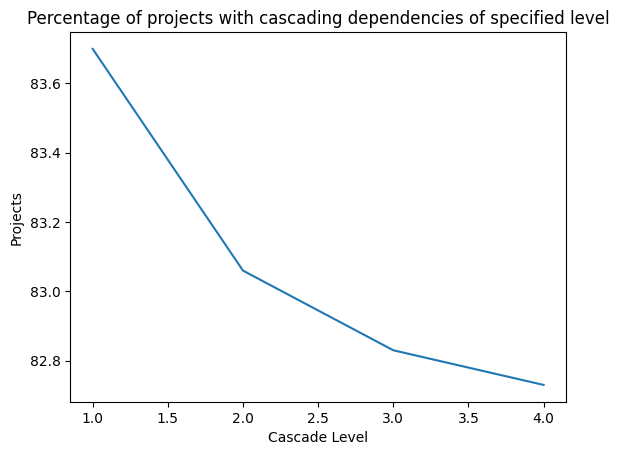

In [12]:
import matplotlib.pyplot as plt

# Input data: array of tuples containing x and y coordinates

# Unpacking the tuples into separate lists for x and y coordinates
x_values = [point[0] for point in cascade_counts]
y_values = [point[1] / project_count * 100 for point in cascade_counts]

# Creating the line plot
plt.plot(x_values, y_values)

# Adding labels and title
plt.xlabel("Cascade Level")
plt.ylabel("Projects")
plt.title("Percentage of projects with cascading dependencies of specified level")

# Displaying the plot
plt.show()

## Transitive dependencies

In [13]:
old_dep_count = {proj_id: len(dependencies[proj_id]) for proj_id in dependencies.keys()}
old_avg_len = sum(old_dep_count.values()) / len(old_dep_count)

print(f'{old_avg_len=}')

old_avg_len=88.50920495690754


In [15]:
from python_proj.data_preprocessing.sliding_window_features.dependency_ecosystem_experience.dependency_loading import (
    calculate_transitive_dependency_map,
)

dependencies = calculate_transitive_dependency_map(dependencies, max_iter=5)

KeyboardInterrupt: 

In [ ]:
new_dep_count = {proj_id: len(dependencies[proj_id]) for proj_id in dependencies.keys()}
new_avg_len = sum(new_dep_count.values()) / len(new_dep_count)

print(f'{new_avg_len=}')

new_avg_len=53.43002341480655


In [ ]:
delta_dep_count = {
    proj_id: new_dep_count[proj_id] - old_dep_count[proj_id]
    for proj_id in old_dep_count.keys()
}
delta_total_dep_count = sum(delta_dep_count.values())
delta_avg_len = delta_total_dep_count / len(delta_dep_count)

print(f"{delta_total_dep_count=}")
print(f"{delta_avg_len=}")

delta_total_dep_count=0
delta_avg_len=0.0
